In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import Adam
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import math
from torch.utils.data import TensorDataset, DataLoader

# 시드 고정
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [62]:
# 입력 및 예측 시퀀스 길이 정의
input_sequence_length = 30
output_sequence_length = 30
sequence_id = 185

In [63]:
data = pd.read_csv('/home/aibig25/hong_sj/trb/num.csv')
data2 = pd.read_csv(f"/home/aibig25/hong_sj/trb/transformer/new/code/mean/visual/Data/{sequence_id}.csv")
data = data.fillna(0)

unique_ids = data['sequence_ID'].unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=41, random_state=42)
train_data = data[data['sequence_ID'].isin(train_ids)]
test_data = data[data['sequence_ID'].isin(test_ids)]

independent_vars = data.columns.difference(['center_x', 'center_y','center_x_ma','center_y_ma', 'ID', 'LC'])
dependent_vars = ['center_y_ma']

scaler = MinMaxScaler()

train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
test_data[independent_vars] = scaler.transform(test_data[independent_vars])

X_train = train_data[independent_vars]
y_train = train_data[dependent_vars]

X_test = test_data[independent_vars]
y_test = test_data[dependent_vars]

/tmp/ipykernel_150589/315913895.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[independent_vars] = scaler.fit_transform(train_data[independent_vars])
/tmp/ipykernel_150589/315913895.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[independent_vars] = scaler.transform(test_data[independent_vars])


In [64]:
# sequence_ID에 해당하는 데이터 필터링 및 스케일링
vehicle_data = data[data['sequence_ID'] == sequence_id].copy()
vehicle_data[independent_vars] = scaler.transform(vehicle_data[independent_vars])
total_frames = len(vehicle_data)

# input_sequence_length와 output_sequence_length를 적용하여 데이터 전처리
def create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length):
    X = []
    y = []
    
    # 마지막 시퀀스까지 처리할 수 있도록 수정
    for i in range(len(vehicle_data) - input_sequence_length + 1):
        X.append(vehicle_data.iloc[i:(i + input_sequence_length)][independent_vars].values)
        if i + input_sequence_length + output_sequence_length <= len(vehicle_data):
            y.append(vehicle_data.iloc[(i + input_sequence_length):(i + input_sequence_length + output_sequence_length)][dependent_vars].values)
        else:
            # 마지막 시퀀스가 output_sequence_length보다 짧으면 0으로 패딩
            remaining_length = len(vehicle_data) - (i + input_sequence_length)
            last_sequence = vehicle_data.iloc[(i + input_sequence_length):][dependent_vars].values
            padded_sequence = np.pad(last_sequence, ((0, output_sequence_length - remaining_length), (0, 0)), mode='constant')
            y.append(padded_sequence)
    
    return np.array(X), np.array(y)

X_vehicle, y_vehicle = create_sequences_for_vehicle(vehicle_data, input_sequence_length, output_sequence_length)

# 데이터셋을 텐서로 변환
vehicle_dataset = TensorDataset(torch.tensor(X_vehicle, dtype=torch.float32), torch.tensor(y_vehicle, dtype=torch.float32))
vehicle_loader = DataLoader(vehicle_dataset, batch_size=10, shuffle=False)

In [65]:
new_row = pd.DataFrame(np.nan, index=[i for i in range(30)], columns=data2.columns)
df = pd.concat([new_row, data2], ignore_index=True)

In [66]:
actual = vehicle_data['center_y_ma'].reset_index(drop=True)
df['Actual'] = actual
df.rename(columns={'Trasformer':'Transformer'})

,Unnamed: 0,Transformer,LSTM,Ours,Actual
0,NaN,NaN,NaN,NaN,519.752
1,NaN,NaN,NaN,NaN,519.752
2,NaN,NaN,NaN,NaN,519.752
3,NaN,NaN,NaN,NaN,519.752
4,NaN,NaN,NaN,NaN,519.752
...,...,...,...,...,...
295,265.0,504.800814,436.585645,515.987793,520.224
296,266.0,504.800814,436.669141,515.844824,520.202
297,267.0,504.800814,436.661035,515.823503,520.174
298,268.0,504.800814,436.569173,515.804883,520.148


In [67]:
df.to_csv(f"/home/aibig25/hong_sj/trb/transformer/new/code/mean/visual/Data/Data2/{sequence_id}.csv")

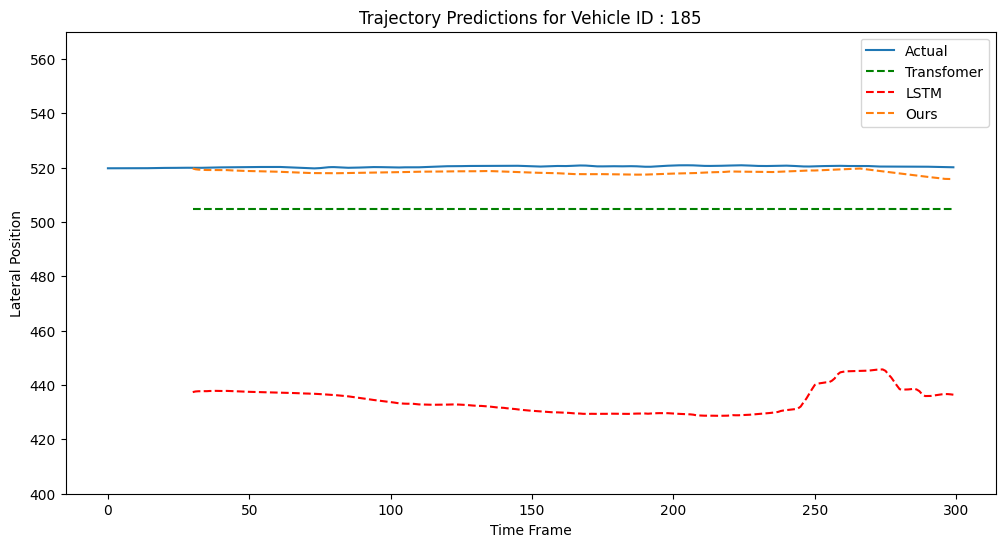

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(vehicle_data)), df['Actual'], label='Actual')  # 전체 실제 궤적
plt.plot(range(0, 0 + len(df["Trasformer"])), 
         df["Trasformer"], label='Transfomer', linestyle='--', color = "green")
plt.plot(range(0, 0 + len(df["LSTM"])), 
         df["LSTM"], label='LSTM', linestyle='--', color = 'red')
plt.plot(range(0, 0 + len(df["Ours"])), 
         df["Ours"], label='Ours', linestyle='--')

plt.xlabel('Time Frame')
plt.ylabel('center_y_ma')
plt.ylabel('Lateral Position')
plt.ylim(400, 570)
plt.title(f'Trajectory Predictions for Vehicle ID : {sequence_id}')
plt.legend()
plt.show()